In [1]:
import os

os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line make pop-out window not appear
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import matplotlib.pyplot as plt
import moviepy.editor as mpy
import numpy as np
import skimage.transform
import tensorflow as tf
import tensorflow.keras.losses as kls
import tensorflow_probability as tfp
from IPython.display import Image, display
from ple import PLE
from ple.games.flappybird import FlappyBird


couldn't import doomish
Couldn't import doom


In [2]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.set_visible_devices(gpus[0], "GPU")

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

        logical_gpus = tf.config.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


1 Physical GPUs, 1 Logical GPUs


In [3]:
game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

test_game = FlappyBird()
test_env = PLE(test_game, fps=30, display_screen=False)
test_env.reset_game()


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

In [4]:
path = "./movie_f"
if not os.path.exists(path):
    os.makedirs(path)


In [5]:
hparas = {
    "image_size": 84,
    "num_stack": 4,
    "action_dim": len(env.getActionSet()),
    "hidden_size": 256,
    "lr": 0.0001,
    "gamma": 0.99,
    "lambda": 0.95,
    "clip_val": 0.2,
    "ppo_epochs": 8,
    "test_epochs": 1,
    "num_steps": 512,
    "mini_batch_size": 64,
    "target_reward": 200,
    "max_episode": 30000,
}


In [6]:
# Please do not modify this method
def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps

    return clip


In [7]:
def preprocess_screen(screen):
    screen = skimage.transform.rotate(screen, -90, resize=True)
    screen = screen[:400, :]
    screen = skimage.transform.resize(
        screen, [hparas["image_size"], hparas["image_size"], 1]
    )
    return screen.astype(np.float32)


def frames_to_state(input_frames):
    if len(input_frames) == 1:
        state = np.concatenate(input_frames * 4, axis=-1)
    elif len(input_frames) == 2:
        state = np.concatenate(input_frames[0:1] * 2 + input_frames[1:] * 2, axis=-1)
    elif len(input_frames) == 3:
        state = np.concatenate(input_frames + input_frames[2:], axis=-1)
    else:
        state = np.concatenate(input_frames[-4:], axis=-1)

    return state


In [8]:
class ActorCriticNetwork(tf.keras.Model):
    def __init__(self, hparas):
        super().__init__()

        self.feature_extractor = tf.keras.Sequential(
            [
                # Convolutional Layers
                tf.keras.layers.Conv2D(filters=32, kernel_size=8, strides=4),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Conv2D(filters=64, kernel_size=4, strides=2),
                tf.keras.layers.ReLU(),
                tf.keras.layers.Conv2D(filters=64, kernel_size=3, strides=1),
                tf.keras.layers.ReLU(),
                # Embedding Layers
                tf.keras.layers.Flatten(),
                tf.keras.layers.Dense(hparas["hidden_size"]),
                tf.keras.layers.ReLU(),
            ]
        )

        # Actor Network
        self.actor = tf.keras.layers.Dense(hparas["action_dim"], activation="softmax")
        # Critic Network
        self.critic = tf.keras.layers.Dense(1, activation=None)

    def call(self, input):
        x = self.feature_extractor(input)
        action_logits = self.actor(x)
        value = self.critic(x)
        return action_logits, value


In [9]:
class Agent:
    def __init__(self, hparas):
        self.gamma = hparas["gamma"]
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=hparas["lr"])
        self.actor_critic = ActorCriticNetwork(hparas)
        self.clip_pram = hparas["clip_val"]

    def ppo_iter(self, mini_batch_size, states, actions, log_probs, returns, advantage):
        batch_size = states.shape[0]
        for _ in range(batch_size // mini_batch_size):
            rand_ids = tf.convert_to_tensor(
                np.random.randint(0, batch_size, mini_batch_size), dtype=tf.int32
            )
            yield (
                tf.gather(states, rand_ids),
                tf.gather(actions, rand_ids),
                tf.gather(log_probs, rand_ids),
                tf.gather(returns, rand_ids),
                tf.gather(advantage, rand_ids),
            )

    def ppo_update(
        self,
        ppo_epochs,
        mini_batch_size,
        states,
        actions,
        log_probs,
        discount_rewards,
        advantages,
    ):
        total_actor_loss = 0
        total_critic_loss = 0
        for _ in range(ppo_epochs):
            for state, action, old_log_probs, reward, advantage in self.ppo_iter(
                mini_batch_size,
                states,
                actions,
                log_probs,
                discount_rewards,
                advantages,
            ):
                reward = tf.expand_dims(reward, axis=-1)

                with tf.GradientTape() as tape:
                    prob, value = self.actor_critic(state, training=True)
                    dist = tfp.distributions.Categorical(probs=prob, dtype=tf.float32)
                    entropy = tf.math.reduce_mean(dist.entropy())
                    new_log_probs = dist.log_prob(action)

                    # PPO ratio
                    ratio = tf.math.exp(new_log_probs - old_log_probs)
                    surr1 = ratio * advantage
                    surr2 = (
                        tf.clip_by_value(
                            ratio, 1.0 - self.clip_pram, 1.0 + self.clip_pram
                        )
                        * advantage
                    )

                    actor_loss = (
                        tf.math.negative(
                            tf.math.reduce_mean(tf.math.minimum(surr1, surr2))
                        )
                        - 0.1 * entropy
                    )
                    critic_loss = 0.5 * tf.math.reduce_mean(
                        kls.mean_squared_error(reward, value)
                    )

                    total_loss = actor_loss + critic_loss

                # single optimizer
                grads = tape.gradient(total_loss, self.actor_critic.trainable_variables)
                self.optimizer.apply_gradients(
                    zip(grads, self.actor_critic.trainable_variables)
                )

                total_actor_loss += actor_loss
                total_critic_loss += critic_loss
        return total_actor_loss, total_critic_loss


In [10]:
# https://arxiv.org/pdf/1506.02438.pdf
# Equation 16
def compute_gae(rewards, masks, values, gamma, LAMBDA):
    gae = 0
    returns = []
    for i in reversed(range(len(rewards))):
        delta = rewards[i] + gamma * values[i + 1] * masks[i] - values[i]
        gae = delta + gamma * LAMBDA * masks[i] * gae
        returns.append(gae + values[i])

    returns.reverse()
    return returns


In [11]:
def test_reward(test_env, agent):
    total_reward = 0
    # Reset the environment
    test_env.reset_game()
    input_frames = [preprocess_screen(test_env.getScreenGrayscale())]

    while not test_env.game_over():
        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        action = np.argmax(prob[0].numpy())
        reward = test_env.act(test_env.getActionSet()[action])
        total_reward += reward

        input_frames.append(preprocess_screen(test_env.getScreenGrayscale()))

    return total_reward


In [12]:
agent = Agent(hparas)
max_episode = hparas["max_episode"]
test_per_n_episode = 10
force_save_per_n_episode = 1000
early_stop_reward = 10

start_s = 0
best_reward = -5.0

checkpoint = tf.train.Checkpoint(
    actor_critic=agent.actor_critic,
    optimizer=agent.optimizer,
)

# Load from old checkpoint
# checkpoint.restore('ckpt_dir/ckpt-?')


In [13]:
ep_reward = []
total_avgr = []
early_stop = False
avg_rewards_list = []

env.reset_game()

for s in range(0, max_episode):
    if early_stop == True:
        break

    rewards = []
    states = []
    actions = []
    log_probs = []
    masks = []
    values = []

    display_frames = [env.getScreenRGB()]
    input_frames = [preprocess_screen(env.getScreenGrayscale())]

    for step in range(hparas["num_steps"]):
        state = frames_to_state(input_frames)
        state = tf.expand_dims(state, axis=0)
        prob, value = agent.actor_critic(state)

        dist = tfp.distributions.Categorical(probs=prob[0], dtype=tf.float32)
        action = dist.sample(1)
        log_prob = dist.log_prob(action)

        reward = env.act(env.getActionSet()[int(action.numpy())])

        done = env.game_over()

        states.append(state)
        actions.append(action)
        values.append(value[0])
        log_probs.append(log_prob)
        rewards.append(tf.convert_to_tensor(reward, dtype=tf.float32))
        masks.append(tf.convert_to_tensor(1 - int(done), dtype=tf.float32))

        display_frames.append(env.getScreenRGB())
        input_frames.append(preprocess_screen(env.getScreenGrayscale()))

        if done:
            env.reset_game()
            input_frames = [preprocess_screen(env.getScreenGrayscale())]

    _, next_value = agent.actor_critic(state)
    values.append(next_value[0])

    returns = compute_gae(rewards, masks, values, hparas["gamma"], hparas["lambda"])

    returns = tf.concat(returns, axis=0)
    log_probs = tf.concat(log_probs, axis=0)
    values = tf.concat(values, axis=0)
    states = tf.concat(states, axis=0)
    actions = tf.concat(actions, axis=0)
    advantage = returns - values[:-1]

    a_loss, c_loss = agent.ppo_update(
        hparas["ppo_epochs"],
        hparas["mini_batch_size"],
        states,
        actions,
        log_probs,
        returns,
        advantage,
    )
    print("[Episode %d]  Actor loss: %.5f, Critic loss: %.5f" % (s, a_loss, c_loss))

    if s % test_per_n_episode == 0:
        # test agent hparas['test_epochs'] times to get the average reward
        avg_reward = np.mean(
            [test_reward(test_env, agent) for _ in range(hparas["test_epochs"])]
        )
        print(
            "Test average reward is %.1f, Current best average reward is %.1f\n"
            % (avg_reward, best_reward)
        )
        avg_rewards_list.append(avg_reward)

        if avg_reward > best_reward:
            best_reward = avg_reward
            agent.actor_critic.save(
                "./save/Actor/model_actor_{}_{}".format(s, avg_reward), save_format="tf"
            )
            checkpoint.save(file_prefix="./save/checkpoints/ckpt")

    if s % force_save_per_n_episode == 0:
        agent.actor_critic.save(
            "./save/Actor/model_actor_{}_{}".format(s, avg_reward), save_format="tf"
        )
        checkpoint.save(file_prefix="./save/checkpoints/ckpt")
        clip = make_anim(display_frames, fps=60, true_image=True).rotate(-90)
        clip.write_videofile("movie_f/{}_demo-{}.webm".format("Lab15", s), fps=60)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1, maxduration=120))

    if best_reward >= early_stop_reward:
        early_stop = True


[Episode 0]  Actor loss: 90.96989, Critic loss: 64.98682
Test average reward is -5.0, Current best average reward is -5.0

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-5.0/assets


INFO:tensorflow:Assets written to: ./save/Actor/model_actor_0_-5.0/assets


Moviepy - Building video movie_f/Lab15_demo-0.webm.
Moviepy - Writing video movie_f/Lab15_demo-0.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-0.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


  reward = env.act(env.getActionSet()[int(action.numpy())])



[Episode 1]  Actor loss: 31.49706, Critic loss: 23.45832
[Episode 2]  Actor loss: 25.18268, Critic loss: 22.13742
[Episode 3]  Actor loss: 12.29295, Critic loss: 11.34300
[Episode 4]  Actor loss: 18.22247, Critic loss: 9.05062
[Episode 5]  Actor loss: 11.01761, Critic loss: 6.65384
[Episode 6]  Actor loss: -2.13119, Critic loss: 4.26302
[Episode 7]  Actor loss: -3.42316, Critic loss: 4.18475
[Episode 8]  Actor loss: -9.80226, Critic loss: 4.47909
[Episode 9]  Actor loss: -0.63850, Critic loss: 3.16258
[Episode 10]  Actor loss: -6.88191, Critic loss: 4.18600
Test average reward is -5.0, Current best average reward is -5.0

[Episode 11]  Actor loss: 0.30770, Critic loss: 4.10415
[Episode 12]  Actor loss: 2.35482, Critic loss: 3.15213
[Episode 13]  Actor loss: -6.15384, Critic loss: 2.82916
[Episode 14]  Actor loss: -7.33719, Critic loss: 2.03846
[Episode 15]  Actor loss: -2.90926, Critic loss: 2.68536
[Episode 16]  Actor loss: -3.35933, Critic loss: 2.29676
[Episode 17]  Actor loss: 3.70

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_50_-4.0/assets
  reward = env.act(env.getActionSet()[int(action.numpy())])



[Episode 51]  Actor loss: -3.57106, Critic loss: 0.48296
[Episode 52]  Actor loss: 1.14953, Critic loss: 0.66639
[Episode 53]  Actor loss: -1.09521, Critic loss: 0.88551
[Episode 54]  Actor loss: 1.00987, Critic loss: 0.74858
[Episode 55]  Actor loss: -2.92870, Critic loss: 0.63985
[Episode 56]  Actor loss: -3.57130, Critic loss: 0.82193
[Episode 57]  Actor loss: -1.72193, Critic loss: 0.54164
[Episode 58]  Actor loss: -5.22274, Critic loss: 0.61427
[Episode 59]  Actor loss: -2.42351, Critic loss: 0.63745
[Episode 60]  Actor loss: -3.75561, Critic loss: 1.76147
Test average reward is -5.0, Current best average reward is -4.0

[Episode 61]  Actor loss: -0.28597, Critic loss: 0.84448
[Episode 62]  Actor loss: -2.48504, Critic loss: 0.87072
[Episode 63]  Actor loss: -6.03368, Critic loss: 0.94987
[Episode 64]  Actor loss: -4.13378, Critic loss: 0.68290
[Episode 65]  Actor loss: -4.63240, Critic loss: 2.09967
[Episode 66]  Actor loss: -1.98554, Critic loss: 0.75022
[Episode 67]  Actor loss

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_370_-3.0/assets
  reward = env.act(env.getActionSet()[int(action.numpy())])



[Episode 371]  Actor loss: -2.69089, Critic loss: 0.30827
[Episode 372]  Actor loss: -5.16640, Critic loss: 0.43363
[Episode 373]  Actor loss: -5.89248, Critic loss: 0.30417
[Episode 374]  Actor loss: -5.29328, Critic loss: 0.25241
[Episode 375]  Actor loss: -4.59371, Critic loss: 0.26074
[Episode 376]  Actor loss: -6.67565, Critic loss: 0.35231
[Episode 377]  Actor loss: -6.71439, Critic loss: 0.19671
[Episode 378]  Actor loss: -1.80463, Critic loss: 0.25093
[Episode 379]  Actor loss: -2.83771, Critic loss: 0.19970
[Episode 380]  Actor loss: -2.58522, Critic loss: 0.47150
Test average reward is -5.0, Current best average reward is -3.0

[Episode 381]  Actor loss: -5.91562, Critic loss: 0.79053
[Episode 382]  Actor loss: -5.31841, Critic loss: 0.47176
[Episode 383]  Actor loss: -3.44733, Critic loss: 0.92291
[Episode 384]  Actor loss: -7.02344, Critic loss: 0.87546
[Episode 385]  Actor loss: -0.98265, Critic loss: 0.63339
[Episode 386]  Actor loss: -3.87018, Critic loss: 0.39217
[Episo

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1000_-5.0/assets


Moviepy - Building video movie_f/Lab15_demo-1000.webm.
Moviepy - Writing video movie_f/Lab15_demo-1000.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-1000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


  reward = env.act(env.getActionSet()[int(action.numpy())])



[Episode 1001]  Actor loss: -17.82111, Critic loss: 2.24889
[Episode 1002]  Actor loss: -10.44849, Critic loss: 1.22510
[Episode 1003]  Actor loss: -4.53880, Critic loss: 1.96967
[Episode 1004]  Actor loss: 5.64344, Critic loss: 1.84521
[Episode 1005]  Actor loss: 1.08535, Critic loss: 0.89393
[Episode 1006]  Actor loss: -1.91832, Critic loss: 1.28236
[Episode 1007]  Actor loss: -1.12660, Critic loss: 1.21965
[Episode 1008]  Actor loss: -8.62201, Critic loss: 0.70873
[Episode 1009]  Actor loss: -4.10110, Critic loss: 0.76820
[Episode 1010]  Actor loss: -7.33478, Critic loss: 1.88931
Test average reward is -5.0, Current best average reward is -3.0

[Episode 1011]  Actor loss: -10.52627, Critic loss: 1.24603
[Episode 1012]  Actor loss: -2.19580, Critic loss: 0.72207
[Episode 1013]  Actor loss: -2.88795, Critic loss: 0.60937
[Episode 1014]  Actor loss: -9.56092, Critic loss: 0.86452
[Episode 1015]  Actor loss: -7.24397, Critic loss: 1.42229
[Episode 1016]  Actor loss: -9.45722, Critic los

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1550_-2.0/assets
  reward = env.act(env.getActionSet()[int(action.numpy())])



[Episode 1551]  Actor loss: -7.08232, Critic loss: 3.59271
[Episode 1552]  Actor loss: -8.18242, Critic loss: 3.56425
[Episode 1553]  Actor loss: -0.49998, Critic loss: 2.09169
[Episode 1554]  Actor loss: -7.19470, Critic loss: 2.31871
[Episode 1555]  Actor loss: -6.72545, Critic loss: 2.85814
[Episode 1556]  Actor loss: -2.47292, Critic loss: 3.52634
[Episode 1557]  Actor loss: -21.28873, Critic loss: 2.14452
[Episode 1558]  Actor loss: -9.23599, Critic loss: 2.47332
[Episode 1559]  Actor loss: 3.98177, Critic loss: 4.86413
[Episode 1560]  Actor loss: 1.38334, Critic loss: 2.44387
Test average reward is -3.0, Current best average reward is -2.0

[Episode 1561]  Actor loss: 10.27851, Critic loss: 1.79799
[Episode 1562]  Actor loss: 2.53719, Critic loss: 2.17876
[Episode 1563]  Actor loss: 8.33372, Critic loss: 3.95168
[Episode 1564]  Actor loss: 3.50298, Critic loss: 1.82417
[Episode 1565]  Actor loss: 8.44023, Critic loss: 2.34819
[Episode 1566]  Actor loss: -9.74113, Critic loss: 0.9

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_1580_3.0/assets
  reward = env.act(env.getActionSet()[int(action.numpy())])



[Episode 1581]  Actor loss: 13.74655, Critic loss: 4.52016
[Episode 1582]  Actor loss: 5.71860, Critic loss: 3.21686
[Episode 1583]  Actor loss: -6.01284, Critic loss: 4.33083
[Episode 1584]  Actor loss: 0.31549, Critic loss: 1.83226
[Episode 1585]  Actor loss: -9.60023, Critic loss: 3.28089
[Episode 1586]  Actor loss: -0.33199, Critic loss: 1.79340
[Episode 1587]  Actor loss: -9.75513, Critic loss: 1.47282
[Episode 1588]  Actor loss: -16.76968, Critic loss: 3.48696
[Episode 1589]  Actor loss: -15.25219, Critic loss: 1.96472
[Episode 1590]  Actor loss: -7.90355, Critic loss: 2.85864
Test average reward is -5.0, Current best average reward is 3.0

[Episode 1591]  Actor loss: -9.16519, Critic loss: 1.84520
[Episode 1592]  Actor loss: -9.07145, Critic loss: 3.69515
[Episode 1593]  Actor loss: -8.47550, Critic loss: 1.28408
[Episode 1594]  Actor loss: -14.22952, Critic loss: 3.18670
[Episode 1595]  Actor loss: -10.66983, Critic loss: 1.56547
[Episode 1596]  Actor loss: -6.78539, Critic los

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2000_-5.0/assets


Moviepy - Building video movie_f/Lab15_demo-2000.webm.
Moviepy - Writing video movie_f/Lab15_demo-2000.webm



Moviepy - Done !
Moviepy - video ready movie_f/Lab15_demo-2000.webm
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


  reward = env.act(env.getActionSet()[int(action.numpy())])



[Episode 2001]  Actor loss: -2.72608, Critic loss: 5.69317
[Episode 2002]  Actor loss: -22.87742, Critic loss: 3.44960
[Episode 2003]  Actor loss: -2.91916, Critic loss: 4.29065
[Episode 2004]  Actor loss: -7.34742, Critic loss: 2.73631
[Episode 2005]  Actor loss: -13.69997, Critic loss: 10.09033
[Episode 2006]  Actor loss: -3.98840, Critic loss: 3.26179
[Episode 2007]  Actor loss: 7.52557, Critic loss: 3.85848
[Episode 2008]  Actor loss: -1.70794, Critic loss: 3.99493
[Episode 2009]  Actor loss: -21.84681, Critic loss: 3.16500
[Episode 2010]  Actor loss: -18.49721, Critic loss: 3.12208
Test average reward is -5.0, Current best average reward is 3.0

[Episode 2011]  Actor loss: -14.24424, Critic loss: 3.61628
[Episode 2012]  Actor loss: -22.45198, Critic loss: 4.32617
[Episode 2013]  Actor loss: 13.37637, Critic loss: 5.72749
[Episode 2014]  Actor loss: -2.23815, Critic loss: 2.99667
[Episode 2015]  Actor loss: -8.71169, Critic loss: 3.16993
[Episode 2016]  Actor loss: -31.82809, Criti

INFO:tensorflow:Assets written to: ./save/Actor/model_actor_2280_12.0/assets


Final episode 2281 reward: 12.0


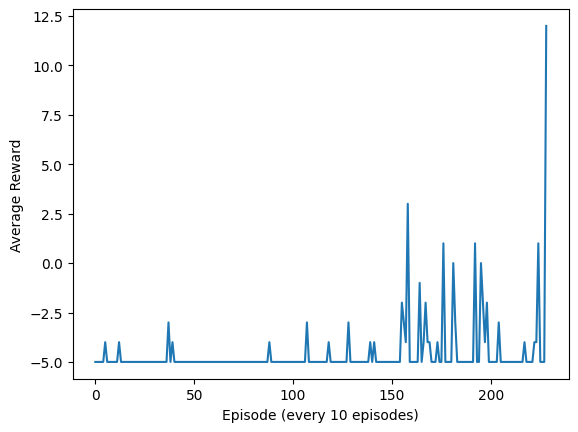

In [20]:
print(f"Final episode {s} reward: {avg_reward}")
plt.plot(avg_rewards_list)
plt.ylabel("Average Reward")
plt.xlabel(f"Episode (every {test_per_n_episode} episodes)")
plt.show()


## Report

由圖上可以看到在 1500 個 Episode 後，就有許多較高 Reward 的 Episode，可以得出在 1500 個 Episode 後就有較大的概率可以飛過一根住子。不過 Test reward 一直都沒有超過 5，一直到 2280 個 Episode 後突然變很高，直接升高到了 12。